Mount Google Drive (optional)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from matplotlib.animation import FuncAnimation
import csv
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# import re
# from bs4 import BeautifulSoup

outputs = {}

In [36]:
class Dense():
    def __init__(self, n_x, n_y, seed=1):
        self.n_x = n_x
        self.n_y = n_y
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Argument:
        self.n_x -- size of the input layer
        self.n_y -- size of the output layer
        self.parameters -- python dictionary containing your parameters:
                           W -- weight matrix of shape (n_x, n_y)
                           b -- bias vector of shape (1, n_y)
        """
        sd = np.sqrt(6.0 / (self.n_x + self.n_y))
        np.random.seed(self.seed)
        W = np.random.uniform(-sd, sd, (self.n_y, self.n_x)).T      # the transpose here is just for the code to be compatible with the old codes
        b = np.zeros((1, self.n_y))

        assert(W.shape == (self.n_x, self.n_y))
        assert(b.shape == (1, self.n_y))

        self.parameters = {"W": W, "b": b}

    def forward(self, A):
        """
        Implement the linear part of a layer's forward propagation.

        Arguments:
        A -- activations from previous layer (or input data) with the shape (n, f^[l-1])
        self.cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently

        Returns:
        Z -- the input of the activation function, also called pre-activation parameter with the shape (n, f^[l])
        """

        # GRADED FUNCTION: linear_forward
        ### START CODE HERE ###
        w = self.parameters["W"]
        b = self.parameters["b"]
        Z = np.dot(A, w) + b
        self.cache = (A, w, b)
        ### END CODE HERE ###

        assert(Z.shape == (A.shape[0], self.parameters["W"].shape[1]))

        return Z

    def backward(self, dZ):
        """
        Implement the linear portion of backward propagation for a single layer (layer l)

        Arguments:
        dZ -- Gradient of the loss with respect to the linear output (of current layer l), same shape as Z
        self.cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
        self.dW -- Gradient of the loss with respect to W (current layer l), same shape as W
        self.db -- Gradient of the loss with respect to b (current layer l), same shape as b

        Returns:
        dA_prev -- Gradient of the loss with respect to the activation (of the previous layer l-1), same shape as A_prev

        """
        A_prev, W, b = self.cache
        m = A_prev.shape[0]

        # GRADED FUNCTION: linear_backward
        ### START CODE HERE ###
        self.dW = np.dot(A_prev.T, dZ) / m
        self.db = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = np.dot(dZ, W.T)
        ### END CODE HERE ###

        assert (dA_prev.shape == A_prev.shape)
        assert (self.dW.shape == self.parameters["W"].shape)
        assert (self.db.shape == self.parameters["b"].shape)

        return dA_prev

    def update(self, learning_rate):
        """
        Update parameters using gradient descent

        Arguments:
        learning rate -- step size
        """

        # GRADED FUNCTION: linear_update_parameters
        ### START CODE HERE ###
        self.parameters["W"] = self.parameters["W"] - learning_rate * self.dW
        self.parameters["b"] = self.parameters["b"] - learning_rate * self.db
        ### END CODE HERE ###

In [37]:
class Activation():
    def __init__(self, activation_function, loss_function):
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.cache = None

    def forward(self, Z):
        if self.activation_function == "sigmoid":
            """
            Implements the sigmoid activation in numpy

            Arguments:
            Z -- numpy array of any shape
            self.cache -- stores Z as well, useful during backpropagation

            Returns:
            A -- output of sigmoid(z), same shape as Z
            """

            # GRADED FUNCTION: sigmoid_forward
            ### START CODE HERE ###
            A = 1 / (1 + np.exp(-Z))
            self.cache = Z
            ### END CODE HERE ###

            return A
        elif self.activation_function == "relu":
            """
            Implement the RELU function in numpy
            Arguments:
            Z -- numpy array of any shape
            self.cache -- stores Z as well, useful during backpropagation
            Returns:
            A -- output of relu(z), same shape as Z

            """

            # GRADED FUNCTION: relu_forward
            ### START CODE HERE ###
            A = np.maximum(0, Z)
            self.cache = Z
            ### END CODE HERE ###

            assert(A.shape == Z.shape)

            return A
        elif self.activation_function == "softmax":
            """
            Implements the softmax activation in numpy

            Arguments:
            Z -- np.array with shape (n, C)
            self.cache -- stores Z as well, useful during backpropagation

            Returns:
            A -- output of softmax(z), same shape as Z
            """

            # GRADED FUNCTION: softmax_forward
            ### START CODE HERE ###
            eZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
            A = eZ / np.sum(eZ, axis=1, keepdims=True)
            self.cache = Z
            ### END CODE HERE ###

            return A
        elif self.activation_function == "linear":
            """
            Linear activation (returns Z directly).
            """
            self.cache = Z.copy()
            return Z

        else:
            raise ValueError(f"Unsupported activation function: {self.activation_function}")


    def backward(self, dA=None, Y=None):
        if self.activation_function == "sigmoid":
            """
            Implement the backward propagation for a single SIGMOID unit.
            Arguments:
            dA -- post-activation gradient, of any shape
            self.cache -- 'Z' where we store for computing backward propagation efficiently
            Returns:
            dZ -- Gradient of the loss with respect to Z
            """

            # GRADED FUNCTION: sigmoid_backward
            ### START CODE HERE ###
            Z = self.cache
            sigmoid = 1 / (1 + np.exp(-Z))
            dZ = dA * sigmoid * (1 - sigmoid)
            ### END CODE HERE ###

            assert (dZ.shape == Z.shape)

            return dZ

        elif self.activation_function == "relu":
            """
            Implement the backward propagation for a single RELU unit.
            Arguments:
            dA -- post-activation gradient, of any shape
            self.cache -- 'Z' where we store for computing backward propagation efficiently
            Returns:
            dZ -- Gradient of the loss with respect to Z
            """

            # GRADED FUNCTION: relu_backward
            ### START CODE HERE ###
            Z = self.cache
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            ### END CODE HERE ###

            assert (dZ.shape == Z.shape)

            return dZ

        elif self.activation_function == "softmax":
            """
            Implement the backward propagation for a [SOFTMAX->CCE LOSS] unit.
            Arguments:
            Y -- true "label" vector (one hot vector, for example: [1,0,0] represents rock, [0,1,0] represents paper, [0,0,1] represents scissors
                                      in a Rock-Paper-Scissors, shape: (n, C)
            self.cache -- 'Z' where we store for computing backward propagation efficiently
            Returns:
            dZ -- Gradient of the cost with respect to Z
            """

            # GRADED FUNCTION: softmax_backward
            ### START CODE HERE ###
            Z = self.cache
            softmax = np.exp(Z - np.max(Z, axis=1, keepdims=True))
            softmax = softmax / np.sum(softmax, axis=1, keepdims=True)
            dZ = softmax - Y
            ### END CODE HERE ###

            assert (dZ.shape == self.cache.shape)

            return dZ

        elif self.activation_function == "linear":
            """
            Backward propagation for linear activation.
            """
            return dA

        else:
            raise ValueError(f"Unsupported activation function: {self.activation_function}")

In [38]:
class Model():
    def __init__(self, units, activation_functions, loss_function):
        self.units = units
        self.activation_functions = activation_functions
        self.loss_function = loss_function
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize layers of the neural network

        Arguments:
            self.units -- array defining network structure (e.g., [4,4,1]):
                - Input layer: 4 nodes
                - Hidden layer: 4 nodes
                - Output layer: 1 node
            self.activation_functions -- activation function for each layer (e.g., ["relu","sigmoid"]):
                - First layer uses ReLU
                - Second layer uses Sigmoid
            self.loss_function -- loss function type: "cross_entropy" or "mse"
        """
        self.linear = []        # Store all Dense layers (weights & biases)
        self.activation = []    # Store all activation function layers

        for i in range(len(self.units)-1):
            dense = Dense(self.units[i], self.units[i+1], i)
            self.linear.append(dense)

        for i in range(len(self.activation_functions)):
            self.activation.append(Activation(self.activation_functions[i], self.loss_function))

    def forward(self, X):
        """
        Forward propagation through the network

        Arguments:
        X -- input data: shape (n, f)
        Returns:
        A -- model output:
            - For binary classification: probability (0-1)
            - For multi-class: probability distribution across classes
            - For regression: predicted values
        """
        A = X

        # GRADED FUNCTION: model_forward
        ### START CODE HERE ###
        for i in range(len(self.linear)):
          Z = self.linear[i].forward(A) # forward
          A = self.activation[i].forward(Z) # activation
        ### END CODE HERE ###

        return A

    def backward(self, AL=None, Y=None):
        """
        Backward propagation to compute gradients

        Arguments:
            AL -- model output from forward propagation:
                - For binary: probability (n,1)
                - For multi-class: probabilities (n,C)
            Y -- true labels:
                - For binary: 0/1 labels (n,1)
                - For multi-class: one-hot vectors (n,C)
                - For regression: true values (n,1)

        Returns:
            dA_prev -- gradients for previous layer's activation
        """

        L = len(self.linear)
        C = Y.shape[1]

        # assertions
        warning = 'Warning: only the following 3 combinations are allowed! \n \
                    1. binary classification: sigmoid + cross_entropy \n \
                    2. multi-class classification: softmax + cross_entropy \n \
                    3. regression: linear + mse'
        assert self.loss_function in ["cross_entropy", "mse"], "you're using undefined loss function!"
        if self.loss_function == "cross_entropy":
            if Y.shape[1] == 1:  # binary classification
                assert self.activation_functions[-1] == 'sigmoid', warning
            else:  # multi-class classification
                assert self.activation_functions[-1] == 'softmax', warning
                assert self.units[-1] == Y.shape[1], f"you should set last dim to {Y.shape[1]}(the number of classes) in multi-class classification!"
        elif self.loss_function == "mse":
            assert self.activation_functions[-1] == 'linear', warning
            assert self.units[-1] == Y.shape[1], "output dimension mismatch for regression!"

        # GRADED FUNCTION: model_backward
        ### START CODE HERE ###
        dAL = 0.0
        # Initializing the backpropagation
        if self.loss_function == "cross_entropy":
          dAL = (-1 * (Y / (AL + 0.00001))) + ((1 - Y) / (1 - AL + 0.00001))
        elif self.loss_function == "mse":
          dAL = AL - Y

        if self.activation_functions[-1] == "linear":
          # Lth layer (LINEAR) gradients. Inputs: "dAL". Outputs: "dA_prev"
          dZ = dAL
          dA_prev = self.linear[-1].backward(dZ)

        elif self.activation_functions[-1] == "sigmoid":
          # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL". Outputs: "dA_prev"
          dZ = self.activation[-1].backward(dAL)
          dA_prev = self.linear[-1].backward(dZ)

        elif self.activation_functions[-1] == "softmax":
          dZ = self.activation[-1].backward(Y=Y)
          dA_prev = self.linear[-1].backward(dZ)

        # Loop from l=L-2 to l=0
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "dA_prev". Outputs: "dA_prev"
        for l in reversed(range(L - 1)):
          dZ = self.activation[l].backward(dA_prev)
          dA_prev = self.linear[l].backward(dZ)
        ### END CODE HERE ###

        return dA_prev

    def update(self, learning_rate):
        """
        Arguments:
        learning_rate -- step size
        """

        L = len(self.linear)

        # GRADED FUNCTION: model_update_parameters
        ### START CODE HERE ###
        for l in self.linear:
          l.update(learning_rate)
        ### END CODE HERE ###

In [39]:
def compute_MSE_loss(AL, Y):
    # 檢查 AL 和 Y 是否有 NaN 或無效值
    if np.any(np.isnan(AL)) or np.any(np.isnan(Y)):
        raise ValueError("AL or Y contains NaN values!")
    if np.any(np.isinf(AL)) or np.any(np.isinf(Y)):
        raise ValueError("AL or Y contains Inf values!")
    
    # 防止 m 為 0
    m = Y.shape[0]
    if m == 0:
        raise ValueError("Number of samples (m) is zero, cannot compute loss.")
    
    # 計算 MSE loss
    loss = (1 / m) * np.sum(np.square(AL - Y))
    return loss

# compute_MSE_loss (MSE)
def compute_MSE_loss(AL, Y):
    m = Y.shape[0]
    loss = (1/m) * np.sum(np.square(AL - Y))
    return loss

In [40]:
# def predict(x, y_true, model):
#     """
#     This function is used to predict the results of a  L-layer neural network.

#     Arguments:
#     x -- data set of examples you would like to label
#     model -- trained model

#     Returns:
#     y_pred -- predictions for the given dataset X
#     """

#     n = x.shape[0]

#     # Forward propagation
#     y_pred = model.forward(x)

#     # this transform the output and label of binary classification when using sigmoid + cross entropy for evaluation
#     # eg. y_pred: [[0.8], [0.2], [0.1]] -> [[0.2, 0.8], [0.8, 0.2], [0.9, 0.1]]
#     # eg. y_true: [[1], [0], [0]] -> [[0, 1], [1, 0], [1, 0]]
#     if y_pred.shape[-1] == 1:
#         y_pred = np.array([[1 - y[0], y[0]] for y in y_pred])
#         if y_true is not None:
#             y_true = np.array([[1,0] if y == 0 else [0,1] for y in y_true.reshape(-1)])

#     # make y_pred/y_true become one-hot prediction result
#     # eg. y_true: [[1, 0, 0], [0, 0, 1], [0, 1, 0]] -> [0, 2, 1]
#     # eg. y_pred: [[0.2, 0.41, 0.39], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]] -> [1, 1, 2]
#     if y_true is not None:
#         y_true = np.argmax(y_true, axis=1)
#     y_pred = np.argmax(y_pred, axis=1)

#     if y_true is not None:
#         # compute accuracy
#         correct = 0
#         for yt, yp in zip(y_true, y_pred):
#             if yt == yp:
#                 correct += 1
#         print(f"Accuracy: {correct/n * 100:.2f}%")

#         # f1_scores = f1_score(y_true, y_pred, average=None)
#         # print(f'f1 score for each class: {f1_scores}')
#         # print(f'f1_macro score: {np.mean(np.array(f1_scores)):.2f}')
#         MAPE = calculate_MAPE(y_pred, y_true)
#         print(f"MAPE: {MAPE}")

#     return y_pred

def save_prediction_data(predicted_y):
    # Create DataFrame with ID, x, and y columns
    df = pd.DataFrame({
        'ID': range(len(predicted_y)),  # Add ID column starting from 0
        'y': predicted_y
    })

    # Ensure ID is the first column
    df = df[['ID', 'y']]

    # Save to CSV file
    df.to_csv('Lab4_basic_regression.csv', index=False)
    print("Prediction data saved as 'Lab4_basic_regression.csv'")

def animate_training(history, X_train, Y_train):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 11)
    ax.set_ylim(-5, 5)
    line, = ax.plot([], [], 'b-', lw=1, label='Predicted')

    ground_truth_x = X_train.flatten()
    ground_truth_y = Y_train.flatten()
    ax.plot(ground_truth_x, ground_truth_y, 'r-', lw=1, label='Ground Truth')

    # show current epoch on the animation / 100 epoch
    epoch_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    def init():
        line.set_data([], [])
        epoch_text.set_text('')
        return line, epoch_text

    def update(frame):
        epoch = (frame + 1) * 100
        _, predicted_y = history[frame]
        predicted_x = X_train.flatten()
        line.set_data(predicted_x, predicted_y.flatten())

        epoch_text.set_text(f'Epoch: {epoch}')

        return line, epoch_text

    ani = FuncAnimation(fig, update, frames=len(history), init_func=init, blit=True, interval=50)

    # save as gif
    ani.save('Lab4_basic_regression.gif', writer='pillow')
    plt.close(fig)
    print(f"Animation saved as 'Lab4_basic_regression.gif'")


def save_final_result(model, X_train, Y_train):
    AL = model.forward(X_train)

    predicted_x = X_train.flatten()
    predicted_y = AL.flatten()

    plt.plot(predicted_x, predicted_y, 'b-', label="Predicted", lw=1)

    ground_truth_x = X_train.flatten()
    ground_truth_y = Y_train.flatten()

    save_prediction_data(predicted_y)

    plt.plot(ground_truth_x, ground_truth_y, 'r-', label='Ground Truth', lw=1)

    plt.legend()

    plt.ylim(-5, 5)
    plt.xlim(0, 11)
    plt.savefig("Lab4_basic_regression.jpg")
    plt.show()
    print("Prediction saved as 'Lab4_basic_regression.jpg'")



In [41]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (n, f^{0})
    Y -- true "label" vector, of shape (n, C)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    ### START CODE HERE ###

    # Step 1: Shuffle (X, Y)
    # permutation = list(np.random.permutation(m))
    # shuffled_X = X[permutation, :]
    # shuffled_Y = Y[permutation, :]

    permutation = np.random.permutation(m)
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        # mini_batch_X = shuffled_X[k * mini_batch_size : m - 1]
        # mini_batch_Y = shuffled_Y[k * mini_batch_size : m - 1]
        # mini_batch = (mini_batch_X, mini_batch_Y)
        # mini_batches.append(mini_batch)

    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    ### END CODE HERE ###

    return mini_batches

def train_model(model, X_train, Y_train, learning_rate, num_iterations, batch_size=None, print_loss=True, print_freq=1000, decrease_freq=100, decrease_proportion=0.99):
    """
    Trains the model using mini-batch gradient descent

    Arguments:
    model -- the model to be trained
    X_train -- training set, of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels, of shape (1, m_train)
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    batch_size -- size of a mini batch
    print_loss -- if True, print the loss every print_freq iterations
    print_freq -- print frequency
    decrease_freq -- learning rate decrease frequency
    decrease_proportion -- learning rate decrease proportion

    Returns:
    model -- the trained model
    losses -- list of losses computed during the optimization
    history -- list of (X_train, Y_pred) tuples for visualization
    """

    history = []
    losses = []

    for i in range(num_iterations):
        ### START CODE HERE ###
        # Define mini batches
        mini_batches = [(X_train, Y_train)]
        if batch_size:
            mini_batches = random_mini_batches(X_train, Y_train, batch_size)
        else:
            # if batch_size is None, batch is not used, mini_batch = whole dataset
            mini_batches = [(X_train, Y_train)]

        epoch_loss = 0
        for batch in mini_batches:
            X_batch, Y_batch = batch

            # Forward pass
            AL = model.forward(X_batch)

            # Compute loss
            # if model.loss_function == 'cross_entropy':
            #     if model.activation_functions[-1] == "sigmoid": # Binary classification
            #         loss = compute_BCE_loss(AL, Y_batch)
            #     elif model.activation_functions[-1] == "softmax": # Multi-class classification
            #         loss = compute_CCE_loss(AL, Y_batch)
            # elif model.loss_function == 'mse': # Regression
            #     loss = compute_MSE_loss(AL, Y_batch)
            loss = compute_MSE_loss(AL, Y_batch)
            epoch_loss += loss

            # Backward pass
            model.backward(AL, Y_batch)

            # Update parameters
            model.update(learning_rate)

        epoch_loss /= len(mini_batches)
        losses.append(epoch_loss)
        ### END CODE HERE ###

        # Print loss
        if print_loss and i % print_freq == 0:
            print(f"Loss after iteration {i}: {epoch_loss}")

        # Store history
        if i % 100 == 0:
            history.append((X_train, model.forward(X_train)))

        # Decrease learning rate
        if i % decrease_freq == 0 and i > 0:
            learning_rate *= decrease_proportion

    return model, losses, history


In [42]:
# def preprocessor(text):
#     # remove HTML tags
#     text = BeautifulSoup(text, 'html.parser').get_text()

#     # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
#     r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
#     emoticons = re.findall(r, text)
#     text = re.sub(r, '', text)

#     # convert to lowercase and append all emoticons behind (with space in between)
#     # replace('-','') removes nose of emoticons
#     text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
#     return text

# nltk.download('stopwords')
# stop = stopwords.words('english')

# def tokenizer_stem_nostop(text):
#     porter = PorterStemmer()
#     return [porter.stem(w) for w in re.split('\s+', text.strip()) \
#             if w not in stop and re.match('[a-zA-Z]+', w)]


In [43]:
def preProcessed(x, y):
    y = y[:, np.newaxis]
    combined = np.hstack((x, y))
    nan_removed = combined[~np.isnan(combined).any(axis=1)]
    x_train = nan_removed[:, :-1]
    y_train = nan_removed[:, -1:]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    y_train = scaler.fit_transform(y_train)
    x_train[:, 0] = np.where(x_train[:, 0] > 0, np.log10(x_train[:, 0].clip(min=1e-10)), x_train[:, 0])
    x_train[:, 1] = np.where(x_train[:, 1] > 0, np.log10(x_train[:, 1].clip(min=1e-10)), x_train[:, 1])
    x_train[:, 2] = np.where(x_train[:, 2] > 0, np.log10(x_train[:, 2].clip(min=1e-10)), x_train[:, 2])
    y_train[:, 0] = np.where(y_train[:, 0] > 0, np.log10(y_train[:, 0].clip(min=1e-10)), y_train[:, 0])
    # x_train = (x_train - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)
    # y_train = (y_train - np.mean(y_train)) / np.std(y_train)
    return x_train, y_train

In [44]:
def split_data(X_train, Y_train, split_ratio=0.2):

    x_split_size = int(len(X_train) * split_ratio)
    y_split_size = int(len(Y_train) * split_ratio)
    x_train = X_train[x_split_size:]
    y_train = Y_train[y_split_size:]
    x_val = X_train[:x_split_size]
    y_val = Y_train[:y_split_size]

    return x_train, y_train, x_val, y_val


In [45]:
# load training data
data_root = "out.csv"
with open(data_root, newline='') as csvfile:
    datalist = pd.read_csv(data_root)

In [46]:
# count = CountVectorizer(ngram_range=(1, 1),
#                         preprocessor=preprocessor,
#                         tokenizer=tokenizer_stem_nostop)
# datal = datalist.to_numpy()
# count.fit(datal[:,7])
# BoW = count.vocabulary_
# print('[vocabulary]\n{}'.format(BoW))
# doc_bag = count.transform(datal[:,7])
# doc_bag = doc_bag.toarray()
# print(doc_bag)

x_train shape: (1585, 3), y_train shape: (1585, 1)
x_val shape: (396, 3), y_val shape: (396, 1)
Loss after iteration 0: 0.007475833864810935
Loss after iteration 1000: 0.003411428869782586
Loss after iteration 2000: 0.0026174763317550515
Loss after iteration 3000: 0.0023224122785730408
Loss after iteration 4000: 0.0022501750504314347
Loss after iteration 5000: 0.001930355755548002
Loss after iteration 6000: 0.0017258647340779257
Loss after iteration 7000: 0.0015727958395291334
Loss after iteration 8000: 0.0014161659373750923
Loss after iteration 9000: 0.0013272729811390901
Loss after iteration 10000: 0.0012516631985159943
Loss after iteration 11000: 0.0010960760346552536
Loss after iteration 12000: 0.0010731016869546751
Loss after iteration 13000: 0.0010305310076017852
Loss after iteration 14000: 0.0010032412665359521
Loss after iteration 15000: 0.0009802003471382607
Loss after iteration 16000: 0.0009590710349774613
Loss after iteration 17000: 0.0009455071093311279
Loss after iteration

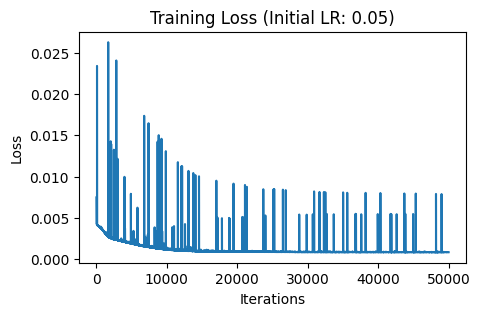

In [47]:
# filtered_data = datalist[(datalist["followers"] > 10000) & (datalist["followers"] < 1000000)]
# data_isVideo = filtered_data[filtered_data["is Photo"] == 0]
data_isVideo = datalist[(datalist["followers"] > 10) & (datalist["followers"] < 10000) & (datalist["is Video"] == 1)]
# xy = filtered_data[[ "followers","is Photo", "hashtag_count", "days_diff", "Like Count"]].to_numpy()
xy_isVideo = data_isVideo[[ "followers", "hashtag_count", "days_diff", "Like Count"]].to_numpy()

x_isVideo = xy_isVideo[:, :-1]  
y_isVideo = xy_isVideo[:, -1]   
x_processed_isVideo, y_processed_isVideo = preProcessed(x_isVideo, y_isVideo)
x_train_isVideo, y_train_isVideo, x_val_isVideo, y_val_isVideo = split_data(x_processed_isVideo, y_processed_isVideo, split_ratio=0.2)
print(f"x_train shape: {x_train_isVideo.shape}, y_train shape: {y_train_isVideo.shape}")
print(f"x_val shape: {x_val_isVideo.shape}, y_val shape: {y_val_isVideo.shape}")

loss_function = "mse";
layers_dims = [x_train_isVideo.shape[-1], 32, 16, 1] # linear for converge, sigmoid for diverge
activation_fn = ["relu", "relu", "linear"]
learning_rate = 0.05
num_iterations = 50000
print_loss = True
print_freq = 1000
decrease_freq = 1000
decrease_proportion = 0.9
batch_size = 16 

model_isVideo = Model(layers_dims, activation_fn, loss_function)
model_isVideo, losses, history = train_model(model_isVideo, x_train_isVideo, y_train_isVideo, learning_rate, num_iterations, batch_size, print_loss, print_freq, decrease_freq, decrease_proportion)

# Plot the loss
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Training Loss (Initial LR: {learning_rate})')
plt.show()

x_train shape: (1572, 3), y_train shape: (1572, 1)
x_val shape: (392, 3), y_val shape: (392, 1)
Loss after iteration 0: 0.0022333453759689264
Loss after iteration 1000: 2.760586949373095e-06
Loss after iteration 2000: 1.6100113947689027e-06
Loss after iteration 3000: 1.206897926083247e-06
Loss after iteration 4000: 1.0164726434786984e-06
Loss after iteration 5000: 9.178785094729081e-07
Loss after iteration 6000: 8.475100393446006e-07
Loss after iteration 7000: 7.909645092048214e-07
Loss after iteration 8000: 7.461022574266681e-07
Loss after iteration 9000: 6.394855195252002e-07
Loss after iteration 10000: 5.705816621665087e-07
Loss after iteration 11000: 5.401520138751693e-07
Loss after iteration 12000: 5.204887463168097e-07
Loss after iteration 13000: 5.027685209162537e-07
Loss after iteration 14000: 4.920292041420676e-07
Loss after iteration 15000: 4.843582243034365e-07
Loss after iteration 16000: 4.741394446317862e-07
Loss after iteration 17000: 4.6582272376921344e-07
Loss after ite

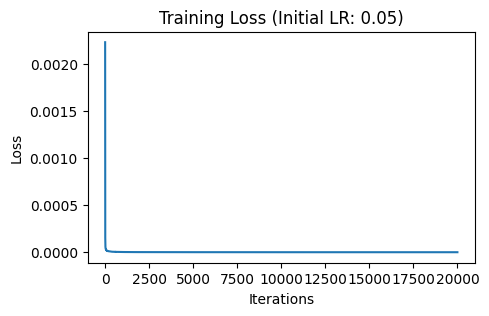

In [57]:
# data_isPhoto = filtered_data[filtered_data["is Photo"] == 1]
data_isPhoto = datalist[(datalist["followers"] > 10000) & (datalist["followers"] < 1000000) & (datalist["is Photo"] == 1)]
xy_isPhoto = data_isPhoto[[ "followers", "hashtag_count", "days_diff", "Like Count"]].to_numpy()

x_isPhoto = xy_isPhoto[:, :-1]  
y_isPhoto = xy_isPhoto[:, -1]   
x_processed_isPhoto, y_processed_isPhoto = preProcessed(x_isPhoto, y_isPhoto)
x_train_isPhoto, y_train_isPhoto, x_val_isPhoto, y_val_isPhoto = split_data(x_processed_isPhoto, y_processed_isPhoto, split_ratio=0.2)
print(f"x_train shape: {x_train_isPhoto.shape}, y_train shape: {y_train_isPhoto.shape}")
print(f"x_val shape: {x_val_isPhoto.shape}, y_val shape: {y_val_isPhoto.shape}")

loss_function = "mse";
layers_dims = [x_train_isPhoto.shape[-1], 32, 16, 1] # linear for converge, sigmoid for diverge
activation_fn = ["relu", "relu", "linear"]
learning_rate = 0.05
num_iterations = 20000
print_loss = True
print_freq = 1000
decrease_freq = 1000
decrease_proportion = 0.9
batch_size = 16 

model_isPhoto = Model(layers_dims, activation_fn, loss_function)
model_isPhoto, losses, history = train_model(model_isPhoto, x_train_isPhoto, y_train_isPhoto, learning_rate, num_iterations, batch_size, print_loss, print_freq, decrease_freq, decrease_proportion)

# Plot the loss
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Training Loss (Initial LR: {learning_rate})')
plt.show()

In [49]:
def calculate_MAPE(prediction, ground_truth):
    ground_truth = np.where(ground_truth == 0, np.finfo(float).eps, ground_truth) # ensure no 0 in nparray
    mape = np.sum(np.abs((ground_truth - prediction) / ground_truth)) / len(prediction) * 100
    return mape

def predict(x, y_true, model):
    # 預測
    y_pred = model.forward(x)
    
    if y_true is not None:
        # Mean Squared Error
        mse = np.mean(np.square(y_pred - y_true))
        print(f"MSE : {mse}")

        # Mean Absolute Error
        mae = np.mean(np.abs(y_pred - y_true))
        print(f"MAE : {mae}")

        mape = calculate_MAPE(y_true, y_pred)
        print(f"MAPE {mape:.2f}%")

        # Accuracy (within tolerance)
        # tolerance = 1e-3 
        # correct = np.sum(np.isclose(y_pred.flatten(), y_true.flatten(), atol=tolerance))
        # accuracy = correct / len(y_true) * 100
        # print(f"Accuracy (within tolerance of {tolerance}): {accuracy:.2f}%")
    
    return y_pred


In [50]:
# # load validation data
# data_val_root = "out.csv"
# with open(data_val_root, newline='') as csvfile:
#     datalist_val = pd.read_csv(data_val_root)

# filtered_data_val = datalist_val[(datalist_val["followers"] > 10000) & (datalist_val["followers"] < 1000000)]
# data_val_isVideo = filtered_data_val[filtered_data_val["is Photo"] == 0]
# xy_val_isVideo = data_val_isVideo[[ "followers", "hashtag_count", "days_diff", "Like Count"]].to_numpy()

# x_val_isVideo = xy_val_isVideo[:, :-1]  
# y_val_isVideo = xy_val_isVideo[:, -1]   
# x_val_processed_isVideo, y_processed_isVideo = preProcessed(x_isVideo, y_isVideo)

# data_val_isPhoto = filtered_data_val[filtered_data_val["is Photo"] == 1]
# xy_val_isPhoto = data_val_isPhoto[[ "followers", "hashtag_count", "days_diff", "Like Count"]].to_numpy()

# x_val_isPhoto = xy_val_isPhoto[:, :-1]  
# y_val_isPhoto = xy_val_isPhoto[:, -1]   
# x_val_processed_isPhoto, y_processed_isPhoto = preProcessed(x_isPhoto, y_isPhoto)

In [58]:
print("photo post predict:")
print("training data")
pred_train = predict(x_train_isPhoto, y_train_isPhoto, model_isPhoto)
print("validation data")
pred_val = predict(x_val_isPhoto, y_val_isPhoto, model_isPhoto)
print("video post predict:")
print("training data")
pred_train = predict(x_train_isVideo, y_train_isVideo, model_isVideo)
print("validation data")
pred_val = predict(x_val_isVideo, y_val_isVideo, model_isVideo)
# save_final_result(model, x_train, y_train)
# animate_training(history, x_train, y_train)

photo post predict:
training data
MSE : 4.5372990877749997e-07
MAE : 0.0003792644961862779
MAPE 1.68%
validation data
MSE : 0.007113541377323384
MAE : 0.0050181057407585935
MAPE 21.89%
video post predict:
training data
MSE : 0.0008496013252137939
MAE : 0.004335430942835059
MAPE 21.93%
validation data
MSE : 0.07477262665232576
MAE : 0.12460782748875279
MAPE 57.39%


In [52]:
df = pd.DataFrame({
    'ID': range(len(pred_train)),
    'Label': pred_train.flatten()
})

df.to_csv('training_output.csv', index=False)
print("Prediction data saved as 'training_output.csv'")

Prediction data saved as 'training_output.csv'
